## Libaries

In [1]:
# Main libraries installation
!pip install geopandas requests contextily > nul

In [2]:
# Upgrade key libraries
!pip install --upgrade contextily geopandas rasterio pip > nul

In [3]:
# Import necessary libraries
import geopandas as gpd      # For working with geospatial data
import pandas as pd          # For data manipulation and analysis
import os                    # For operating system-related functionality
import io                    # For input/output operations
import contextily as cx      # For basemaps and context tiles
import matplotlib.pyplot as plt  # For creating visualizations
from rasterio.crs import CRS  # For handling coordinate reference systems

## Data Ingestion

In [4]:
# Path to the shapefile
shp_path = 'data/us_states/tl_2022_us_state.shp'

# Load the shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(shp_path)

## Data exploring

In [5]:
# Display information about the GeoDataFrame
gdf_shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   REGION    56 non-null     object  
 1   DIVISION  56 non-null     object  
 2   STATEFP   56 non-null     object  
 3   STATENS   56 non-null     object  
 4   GEOID     56 non-null     object  
 5   STUSPS    56 non-null     object  
 6   NAME      56 non-null     object  
 7   LSAD      56 non-null     object  
 8   MTFCC     56 non-null     object  
 9   FUNCSTAT  56 non-null     object  
 10  ALAND     56 non-null     int64   
 11  AWATER    56 non-null     int64   
 12  INTPTLAT  56 non-null     object  
 13  INTPTLON  56 non-null     object  
 14  geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 6.7+ KB


In [6]:
# Display the first few rows of the GeoDataFrame
gdf_shapefile.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266456923,489045863,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138962819934,45971472526,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778515726,6216539665,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206244837557,18937184315,+46.3159573,-094.1996043,"POLYGON ((-95.31989 48.99892, -95.31747 48.998..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151771744,6979295311,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243..."


In [7]:
# Print the original Coordinate Reference System (CRS) of the GeoDataFrame
print(gdf_shapefile.crs)

GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [8]:
# Reproject the GeoDataFrame to EPSG:3857
gdf_shapefile = gdf_shapefile.to_crs(epsg=3857)

# Print the new Coordinate Reference System (CRS)
print(gdf_shapefile.crs)

EPSG:3857


## Data Visualization

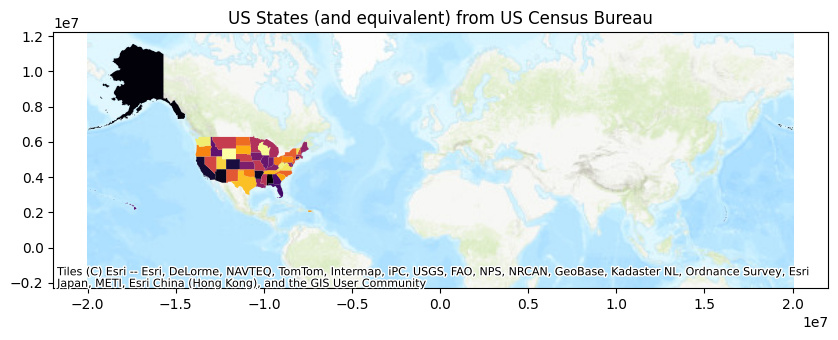

In [9]:
# Create a plot with specified size
fig, ax = plt.subplots(figsize=(10, 6))

# Set alpha to fill the polygons
gdf_shapefile.plot(ax=ax, column='NAME', cmap='inferno', legend=False)

# Add a basemap
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)

# Set the plot title
ax.set_title('US States (and equivalent) from US Census Bureau')

# Display the plot
plt.show()